In [ ]:
from IPython import get_ipython
from IPython.display import display

In [ ]:
!pip install torch
!pip install torch-geometric
!pip install tensorflow
!pip install networkx
!pip install matplotlib
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import torch.nn.functional as F # Import F for using null_loss
from sklearn.neighbors import kneighbors_graph


nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')

# Step 1: Load Data
def load_data(fake_path, true_path):
    fake_df = pd.read_csv(fake_path)
    true_df = pd.read_csv(true_path)
    fake_df['label'] = 0
    true_df['label'] = 1
    df = pd.concat([fake_df, true_df], ignore_index=True)
    df = df[['text', 'label']]
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 2: Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'@\w+|#\w+|http\S+|www\S+|[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Step 3: Prepare Tokenized Data
def prepare_data(df, max_features=500):
    df['text'] = df['text'].apply(preprocess_text)
    texts = df['text'].values
    labels = df['label'].values

    tokenizer = TfidfVectorizer(max_features=max_features)
    X = tokenizer.fit_transform(texts).toarray()
    y = df['label'].values
    max_len = 100

    return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.long), tokenizer

# Step 4: Convert Data to Graph Representation
def create_graph_data(X, y, k=10): # Added k parameter for k-NN
    num_nodes = X.shape[0]
    # Create k-NN graph using cosine similarity
    adj_matrix = kneighbors_graph(X, n_neighbors=k, metric='cosine', mode='connectivity')
    edge_index = torch.tensor(np.argwhere(adj_matrix.toarray() != 0).T, dtype=torch.long) # Changed to kNN Graph

    # Train test split
    X_train, X_test = train_test_split(np.arange(num_nodes), test_size=0.2, stratify=y)
    train_mask = torch.tensor(X_train, dtype=torch.long)
    test_mask = torch.tensor(X_test, dtype=torch.long)

    #edge_index = edge_index.t().contiguous() # Removed this line as it's not needed anymore
    data = Data(x=X, edge_index=edge_index, y=y)
    data.train_mask = train_mask # Corrected to train_mask
    data.test_mask = test_mask
    return data

# Step 5: Define GNN Models
def get_gcn(input_dim, hidden_dim, output_dim):
  class GCNModel(torch.nn.Module):
      def __init__(self):
          super(GCNModel, self).__init__()
          self.conv1 = GCNConv(input_dim, hidden_dim)
          self.conv2 = GCNConv(hidden_dim, output_dim)
          self.relu = nn.ReLU()

      def forward(self, data):
          x, edge_index = data.x, data.edge_index
          x = self.conv1(x, edge_index)
          x = self.relu(x)
          x = self.conv2(x, edge_index)
          return F.log_softmax(x, dim=1)
  return GCNModel()

def get_gat(input_dim, hidden_dim, output_dim):
  class GATModel(torch.nn.Module):
      def __init__(self):
          super(GATModel, self).__init__()
          self.conv1 = GATConv(input_dim, hidden_dim)
          self.conv2 = GATConv(hidden_dim, output_dim)
          self.relu = nn.ReLU()

      def forward(self, data):
          x, edge_index = data.x, data.edge_index
          x = self.conv1(x, edge_index)
          x = self.relu(x)
          x = self.conv2(x, edge_index)
          return F.log_softmax(x, dim=1)
  return GATModel()

def get_graphsage(input_dim, hidden_dim, output_dim):
  class GraphSAGEModel(torch.nn.Module):
      def __init__(self):
          super(GraphSAGEModel, self).__init__()
          self.conv1 = SAGEConv(input_dim, hidden_dim)
          self.conv2 = SAGEConv(hidden_dim, output_dim)
          self.relu = nn.ReLU()

      def forward(self, data):
          x, edge_index = data.x, data.edge_index
          x = self.conv1(x, edge_index)
          x = self.relu(x)
          x = self.conv2(x, edge_index)
          return F.log_softmax(x, dim=1)
  return GraphSAGEModel()

# Step 6: Train & Evaluate Model
def train_and_evaluate(model, data, epochs=20, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        preds = out.argmax(dim=1)
        train_acc = (preds[data.train_mask] == data.y[data.train_mask]).sum().item() / len(data.train_mask)

        model.eval()
        with torch.no_grad():
            val_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask]).item()
            val_acc = (preds[data.test_mask] == data.y[data.test_mask]).sum().item() / len(data.test_mask)

        # Append metrics after each epoch (this is the key change)
        history['train_acc'].append(train_acc)
        history['train_loss'].append(loss.item())
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, Train Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

    return model, history


def evaluate_model(model, data, model_name):
    model.eval()
    with torch.no_grad():
      out = model(data)
      preds = out.argmax(dim=1)
      y_true = data.y[data.test_mask].cpu().numpy()
      y_pred = preds[data.test_mask].cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Calculate ROC and AUC
    probs = out [:, 1].cpu().numpy()
    fpr, tpr, _ = roc_curve(y_true, probs[data.test_mask]) # Extract probability for positive class
    roc_auc = auc(fpr, tpr)

    print(f"{model_name} - Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}, AUC: {roc_auc:.2f}")
    print("Confusion Matrix:")
    print(cm)
    return {
        "model": model,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "conf_matrix": cm,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc
    }

# Plot Training and Validation curve
def plot_history(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.show()
    plt.savefig(f'{model_name}_training and validation accuracy.png')

    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Train Loss') # Changed from history.history['train_loss'] to history['train_loss']
    plt.plot(history['val_loss'], label='Validation Loss') # Changed from history.history['val_loss'] to history['val_loss']
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.show()
    plt.savefig(f'{model_name}_training and validation loss.png')

# Step 6: Plot Confusion Matrix and ROC Curve
def plot_comparison(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    model_names = list(results.keys())
    scores = {metric: [results[model_name][metric] for model_name in model_names] for metric in metrics}

    x = np.arange(len(model_names))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, scores[metric], width, label=metric_names[i])

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Performance Metrics')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Model_Performance_Comparison.png')
    plt.show()

def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

def plot_roc_curves(results):
    plt.figure(figsize=(8, 6))
    for model_name, result in results.items():
        plt.plot(result['fpr'], result['tpr'], lw=2, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig('combined_roc_curve.png')
    plt.show()




[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Using device: cpu

===== Training GCN =====
Epoch 1/20, Train Acc: 0.4878, Train Loss: 0.6954, Val Acc: 0.4832, Val Loss: 0.6958
Epoch 2/20, Train Acc: 0.8663, Train Loss: 0.6255, Val Acc: 0.8650, Val Loss: 0.6249
Epoch 3/20, Train Acc: 0.8809, Train Loss: 0.5504, Val Acc: 0.8817, Val Loss: 0.5490
Epoch 4/20, Train Acc: 0.8863, Train Loss: 0.4737, Val Acc: 0.8875, Val Loss: 0.4714
Epoch 5/20, Train Acc: 0.8900, Train Loss: 0.4081, Val Acc: 0.8930, Val Loss: 0.4049
Epoch 6/20, Train Acc: 0.8923, Train Loss: 0.3581, Val Acc: 0.8952, Val Loss: 0.3540
Epoch 7/20, Train Acc: 0.8949, Train Loss: 0.3216, Val Acc: 0.8994, Val Loss: 0.3170
Epoch 8/20, Train Acc: 0.8983, Train Loss: 0.2957, Val Acc: 0.9022, Val Loss: 0.2909
Epoch 9/20, Train Acc: 0.9024, Train Loss: 0.2775, Val Acc: 0.9079, Val Loss: 0.2731
Epoch 10/20, Train Acc: 0.9053, Train Loss: 0.2643, Val Acc: 0.9102, Val Loss: 0.2604
Epoch 11/20, Train Acc: 0.9081, Train Loss: 0.2543, Val Acc: 0.9131, Val Loss: 0.2510
Epoch 12/20, Train 

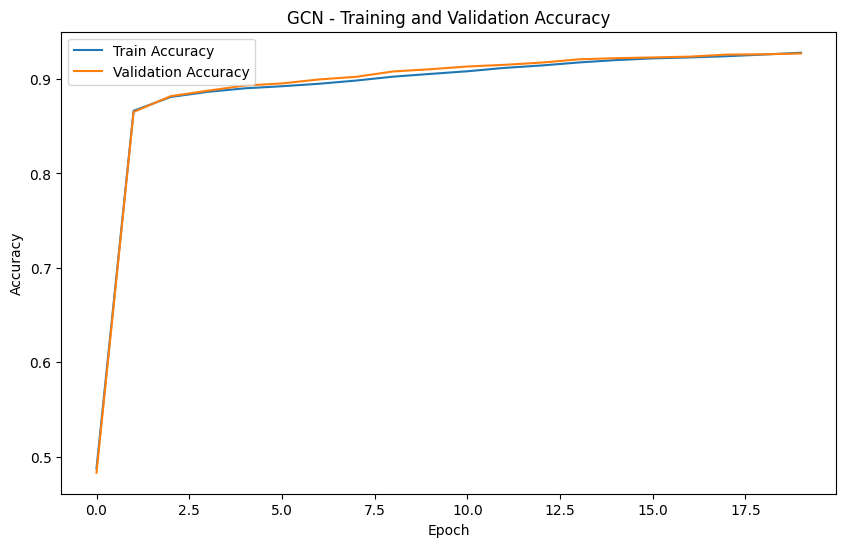

<Figure size 640x480 with 0 Axes>

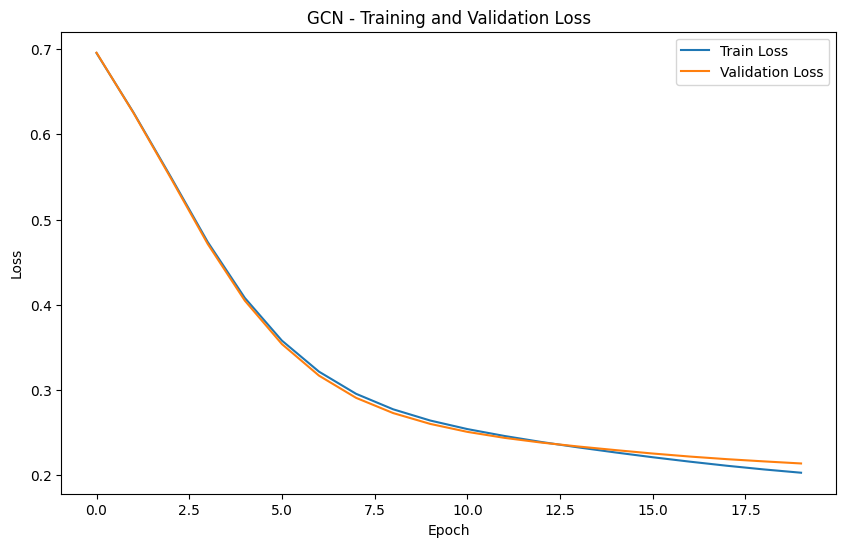


===== Training GAT =====
Epoch 1/20, Train Acc: 0.4954, Train Loss: 0.7012, Val Acc: 0.4923, Val Loss: 0.7012
Epoch 2/20, Train Acc: 0.8437, Train Loss: 0.6479, Val Acc: 0.8425, Val Loss: 0.6480
Epoch 3/20, Train Acc: 0.8731, Train Loss: 0.5905, Val Acc: 0.8720, Val Loss: 0.5905
Epoch 4/20, Train Acc: 0.8901, Train Loss: 0.5224, Val Acc: 0.8923, Val Loss: 0.5220
Epoch 5/20, Train Acc: 0.8928, Train Loss: 0.4558, Val Acc: 0.8954, Val Loss: 0.4545
Epoch 6/20, Train Acc: 0.8909, Train Loss: 0.3994, Val Acc: 0.8949, Val Loss: 0.3970
Epoch 7/20, Train Acc: 0.8934, Train Loss: 0.3525, Val Acc: 0.8978, Val Loss: 0.3492
Epoch 8/20, Train Acc: 0.8984, Train Loss: 0.3139, Val Acc: 0.9026, Val Loss: 0.3101
Epoch 9/20, Train Acc: 0.9023, Train Loss: 0.2861, Val Acc: 0.9055, Val Loss: 0.2819
Epoch 10/20, Train Acc: 0.9036, Train Loss: 0.2674, Val Acc: 0.9080, Val Loss: 0.2627
Epoch 11/20, Train Acc: 0.9057, Train Loss: 0.2545, Val Acc: 0.9081, Val Loss: 0.2491
Epoch 12/20, Train Acc: 0.9073, Train

<Figure size 640x480 with 0 Axes>

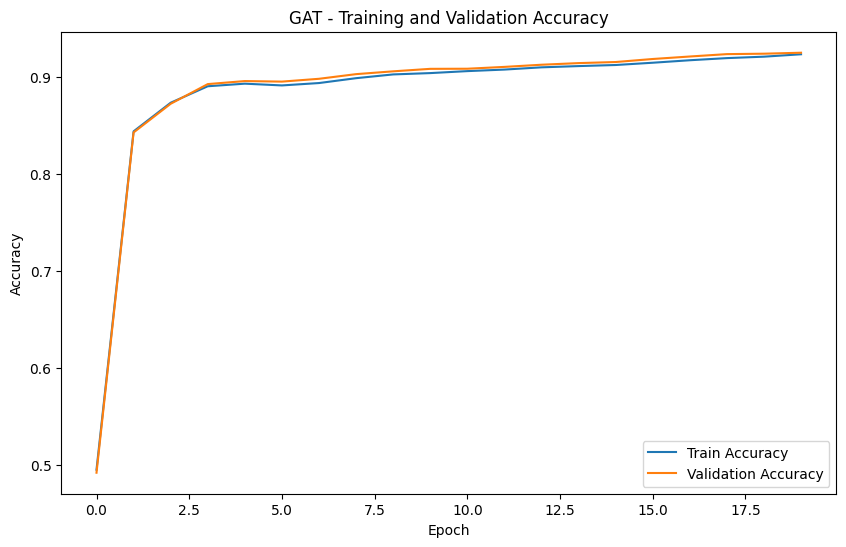

<Figure size 640x480 with 0 Axes>

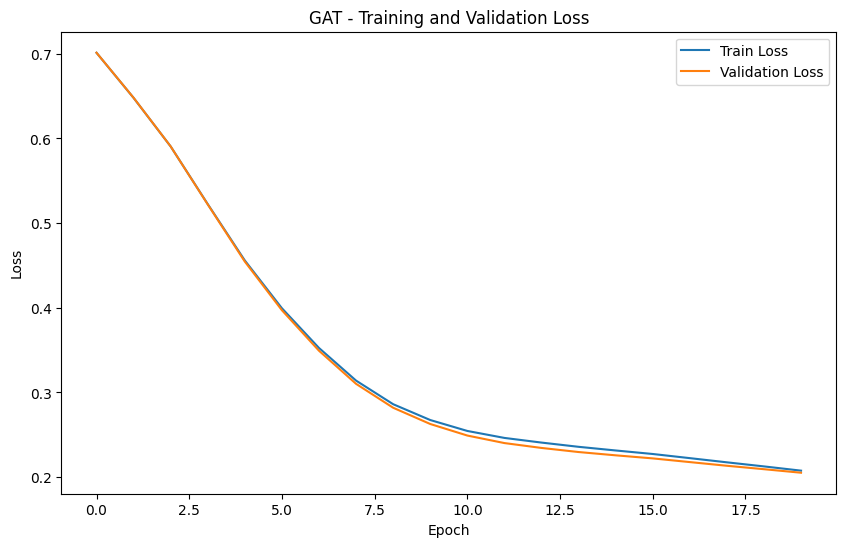


===== Training GraphSAGE =====
Epoch 1/20, Train Acc: 0.5230, Train Loss: 0.6927, Val Acc: 0.5229, Val Loss: 0.6928
Epoch 2/20, Train Acc: 0.7369, Train Loss: 0.6508, Val Acc: 0.7330, Val Loss: 0.6507
Epoch 3/20, Train Acc: 0.8232, Train Loss: 0.5804, Val Acc: 0.8154, Val Loss: 0.5803
Epoch 4/20, Train Acc: 0.8814, Train Loss: 0.4934, Val Acc: 0.8771, Val Loss: 0.4927
Epoch 5/20, Train Acc: 0.9045, Train Loss: 0.4048, Val Acc: 0.9055, Val Loss: 0.4025
Epoch 6/20, Train Acc: 0.9064, Train Loss: 0.3324, Val Acc: 0.9105, Val Loss: 0.3278
Epoch 7/20, Train Acc: 0.9094, Train Loss: 0.2817, Val Acc: 0.9136, Val Loss: 0.2749
Epoch 8/20, Train Acc: 0.9143, Train Loss: 0.2499, Val Acc: 0.9197, Val Loss: 0.2416
Epoch 9/20, Train Acc: 0.9193, Train Loss: 0.2317, Val Acc: 0.9224, Val Loss: 0.2221
Epoch 10/20, Train Acc: 0.9240, Train Loss: 0.2186, Val Acc: 0.9273, Val Loss: 0.2080
Epoch 11/20, Train Acc: 0.9282, Train Loss: 0.2086, Val Acc: 0.9318, Val Loss: 0.1976
Epoch 12/20, Train Acc: 0.9327,

<Figure size 640x480 with 0 Axes>

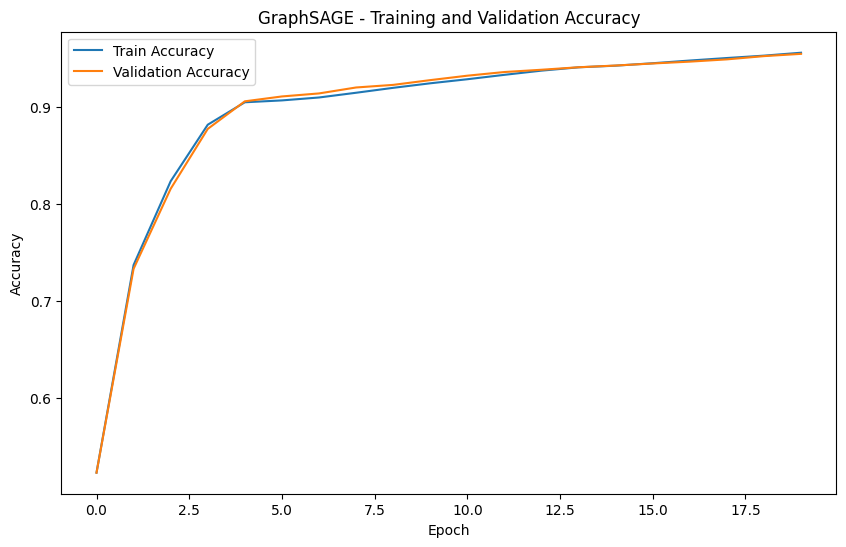

<Figure size 640x480 with 0 Axes>

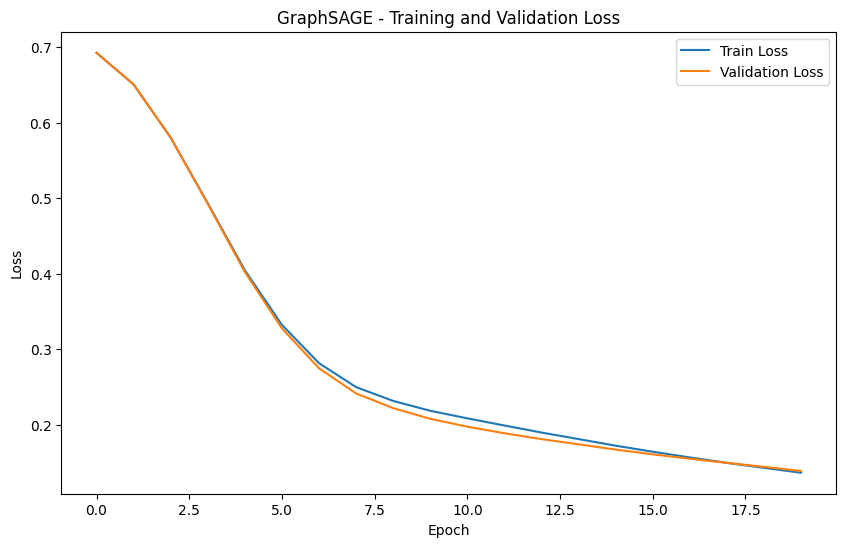

<Figure size 640x480 with 0 Axes>

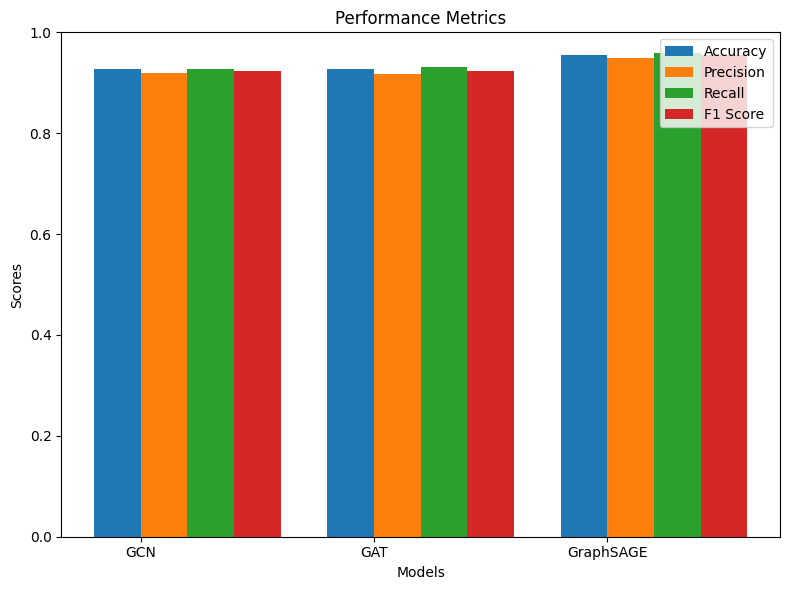

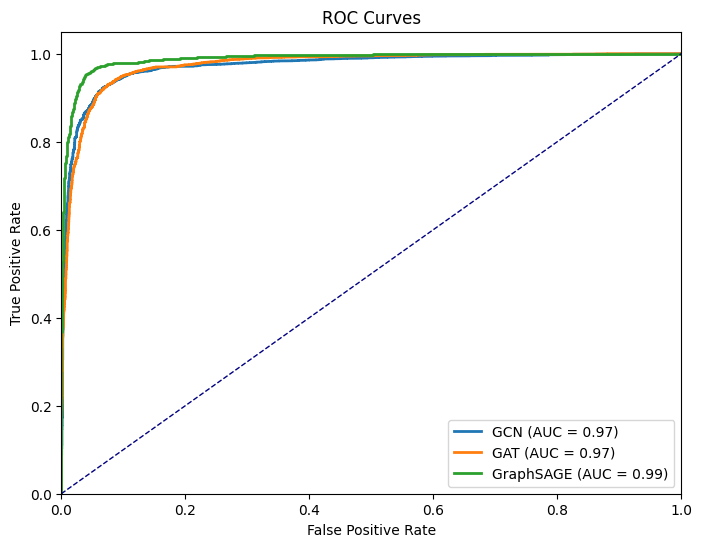

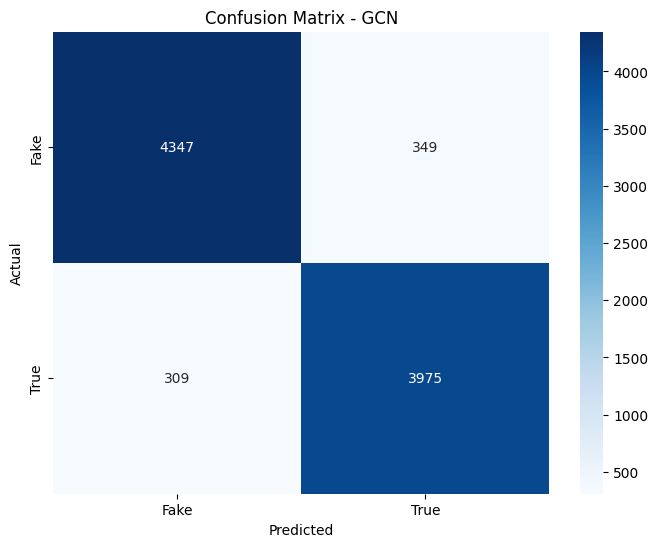

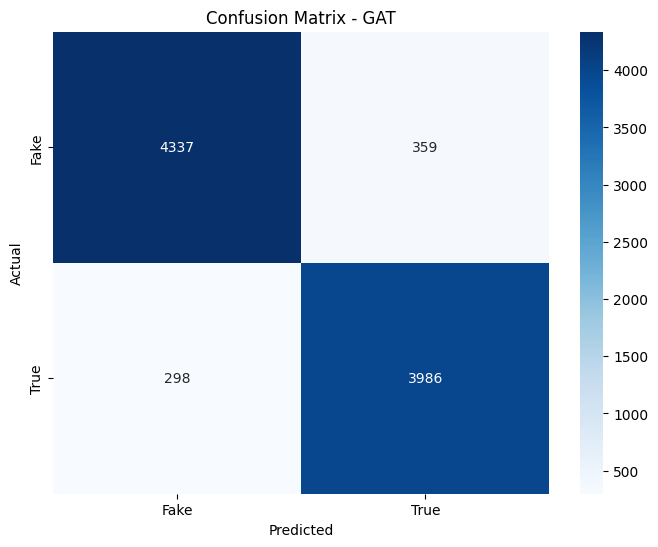

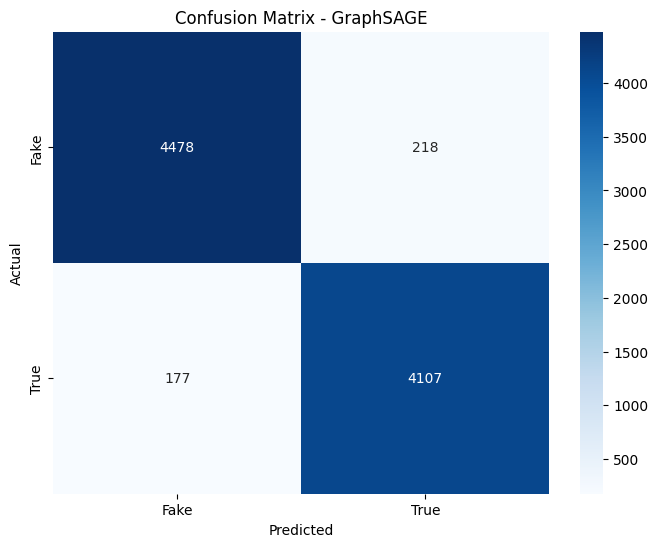

In [ ]:
# Main Execution
def main():
    # Check for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    fake_path = 'fake.csv'
    true_path = 'true.csv'
    df = load_data(fake_path, true_path)
    X, y, _ = prepare_data(df)
    data = create_graph_data(X, y, k=10)

    models = {
        "GCN": get_gcn(input_dim=500, hidden_dim=64, output_dim=2),
        "GAT": get_gat(input_dim=500, hidden_dim=64, output_dim=2),
        "GraphSAGE": get_graphsage(input_dim=500, hidden_dim=64, output_dim=2)
    }

    results = {}
    for model_name, model in models.items():
      print(f"\n===== Training {model_name} =====")
      trained_model, history = train_and_evaluate(model, data)
      result = evaluate_model(trained_model, data, model_name)
      results[model_name] = result
      plot_history(history, model_name)


    plot_comparison(results)# Call the new function to plot performance metrics
    plot_roc_curves(results)# Call the new function to plot combined ROC curves

    for model_name, result in results.items():
        plot_confusion_matrix(result['conf_matrix'], model_name)

if __name__ == "__main__":
    main()